# QTM 347 Final Project
##### By Justin Ross & Nav Vittal

Abstract: This project is an attempt at [Microsoft’s Malware Prediction Kaggle Competition](https://www.kaggle.com/competitions/microsoft-malware-prediction/overview) from 2018. Using a specific train and test datasets, the goal of this project is to predict whether a machine learning model can predict whether a computer has malware given various information about the model. The test and train datasets provided contain information about real Microsoft machines and their malware status. We evaluate performance using area under ROC curve.


### 1) Import Statements

In [ ]:
%pip install pyspark scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 319.9 kB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=7bc1fc619f0d0f676eea678214fd39c158c0d82751333475448bfe0e70e7aea1
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
!spark-server

/bin/bash: line 1: spark-server: command not found


In [ ]:
from pyspark.sql.functions import col, rand, sum
import gc
from pyspark.sql import SparkSession
import pandas as pd

In [ ]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Create a Spark session
spark = SparkSession.builder.appName("Final").getOrCreate()

### 2) Load Data

We have stored our training and test data on Google Drive. To import the CSV files, follow these steps:

Download the 'test.csv' and 'train.csv' files from the following Kaggle competition data link: [Microsoft Malware Prediction Data](https://www.kaggle.com/competitions/microsoft-malware-prediction/data).

Save the downloaded 'test.csv' and 'train.csv' files to your local machine.

Update the file paths in your Python script to point to the local destinations of the 'test.csv' and 'train.csv' files on your machine. Look for the lines of code where the file paths are specified, and replace the existing paths with the paths to the files you downloaded.

By following these steps, you'll be able to use the locally stored CSV files in this notebook.

In [ ]:
train_data_spark = spark.read.csv("/content/gdrive/MyDrive/Final/train.csv", header=True, inferSchema=True)

In [ ]:
train_data_spark.count()

8921483

### 3) Get Stratified Subset and Clean Data

#### 3.1) Stratify data and downsample accordingly

Due to the size of our data and limited RAM capacity (even after purchasing Google Pro+), a stratified subset is taken. The proprtion of computers with malware to computers without malware is found in the train set. The subset size is 50,000 - maximum without crashing.

In [ ]:
target_column = 'HasDetections'

# Set the seed for reproducibility
seed = 42

# Calculate the ratio of positive to negative values in the original dataset
original_ratio = (
    train_data_spark
    .groupBy(target_column)
    .count()
    .select(
        col(target_column),
        (col('count') / train_data_spark.count()).alias('ratio')
    )
    .collect()
)

In [ ]:
original_ratio #essentially a 50/50 ratio

[Row(HasDetections=1, ratio=0.49979269141688665),
 Row(HasDetections=0, ratio=0.5002073085831134)]

In [ ]:
# Set the positive and negative ratios
positive_ratio = .5
negative_ratio = 1 - positive_ratio

# Calculate the number of rows needed for each class in the subset
subset_size = 50000
subset_positive_size = int(subset_size * positive_ratio)
subset_negative_size = int(subset_size * negative_ratio)

# Sample the positive and negative rows to maintain the original ratio
positive_rows = (
    train_data_spark
    .filter(col(target_column) == 1)
    .sample(True, positive_ratio, seed=seed)
    .limit(subset_positive_size)
)

negative_rows = (
    train_data_spark
    .filter(col(target_column) == 0)
    .sample(True, negative_ratio, seed=seed)
    .limit(subset_negative_size)
)

# Concatenate positive and negative rows to create the subset
subset_data_spark = positive_rows.union(negative_rows)

# Shuffle the subset to ensure randomness
subset_data_spark = subset_data_spark.orderBy(rand(seed))

# Display the first few rows of the subset
subset_data_spark.show()

+--------------------+------------+-------------+----------------+------------+------+----------------+----------------+-------------------------+-------------------------+-------------------+-----------------+------+-----------------+--------------+----------------------+-----------------+---------------------------+---------+---------+--------+-------+-------+--------------------+--------------------+----------+-----------+---------------+-------+-----+---------------+------------+--------+------------+---------------------+-------------------+------------------------+-------------------------+-------------------------+--------------------------------------+-------------------------------+---------------------+-------------------------------+--------------------------+--------------------------------+--------------------------+-----------------------+----------------------+-------------------------------------------------+-------------------------------------------------+------------

In [ ]:
train_data = subset_data_spark.toPandas() #convert to Pandas now that dataframe is smaller

In [ ]:
train_machine_ids = train_data["MachineIdentifier"]

#### 3.2) Create Data Dict

Our data dictionary allows us to classify columns as binary, numerical, or categorical. This becomes important for feature selection.

In [ ]:
numeric_columns = ["Census_SystemVolumeTotalCapacity", "Census_TotalPhysicalRAM", "Census_InternalPrimaryDiagonalDisplaySizeInInches", "Census_InternalPrimaryDisplayResolutionHorizontal", "Census_InternalPrimaryDisplayResolutionVertical", "Census_InternalBatteryNumberOfCharges"]
categorical_columns = [col for col in train_data.columns if col not in numeric_columns]

In [ ]:
# Find binary columns
binary_columns = [col for col in train_data.columns if train_data[col].nunique() == 2]
binary_columns.pop() #removes target column

categorical_columns = set(categorical_columns)-set(binary_columns) #final categorical columns

In [ ]:
#Drop all columns that have more than 50% null values

print("Columns w Null % > 50%:")
null_counts_df = pd.DataFrame({'Column': train_data.columns, 'Null Count': train_data.isnull().sum()})
non_null_counts_df = pd.DataFrame({'Column': train_data.columns, 'Non Null Count': train_data.notna().sum()})

null_counts_df["null_counts_percent"] = null_counts_df["Null Count"] / (null_counts_df["Null Count"] + non_null_counts_df["Non Null Count"])

# Filter out columns with zero null values
null_counts_df = null_counts_df[null_counts_df['Null Count'] > 0]

# Order the DataFrame by the count of non-null values in ascending order
null_counts_df = null_counts_df.sort_values(by='null_counts_percent', ascending=False)

# Get column names where the percentage of null values is greater than 50%
columns_with_high_null_percentage = null_counts_df.loc[null_counts_df["null_counts_percent"] > 0.5, 'Column'].tolist()

# Display the resulting list of column names
print(columns_with_high_null_percentage)

train_data = train_data.drop(columns=columns_with_high_null_percentage)
categorical_columns = categorical_columns - set(columns_with_high_null_percentage)
binary_columns = set(binary_columns) - set(columns_with_high_null_percentage)

Columns w Null % > 50%:
['PuaMode', 'Census_ProcessorClass', 'DefaultBrowsersIdentifier', 'Census_IsFlightingInternal', 'Census_InternalBatteryType', 'Census_ThresholdOptIn', 'Census_IsWIMBootEnabled']


In [ ]:
binary_columns.remove("ProductName")
categorical_columns.add("ProductName")
binary_columns.remove("Census_DeviceFamily")
categorical_columns.add("Census_DeviceFamily")

In [ ]:
# Display the column types
print("Categorical columns:")
print(categorical_columns)
print("Binary columns:")
print(binary_columns)
print('Numerical columns:')
print(numeric_columns)

Categorical columns:
{'EngineVersion', 'Census_ProcessorModelIdentifier', 'Census_OEMModelIdentifier', 'OrganizationIdentifier', 'OsBuildLab', 'Census_FirmwareManufacturerIdentifier', 'Census_PrimaryDiskTotalCapacity', 'Census_OSBuildRevision', 'Census_DeviceFamily', 'OsSuite', 'AppVersion', 'RtpStateBitfield', 'OsVer', 'Census_GenuineStateName', 'AVProductStatesIdentifier', 'CityIdentifier', 'Census_OSInstallTypeName', 'ProductName', 'Census_OSEdition', 'AVProductsInstalled', 'Census_MDC2FormFactor', 'OsBuild', 'Census_OSArchitecture', 'Census_FirmwareVersionIdentifier', 'Census_IsFlightsDisabled', 'Census_OSVersion', 'Census_OSUILocaleIdentifier', 'Census_ChassisTypeName', 'Census_PowerPlatformRoleName', 'HasDetections', 'OsPlatformSubRelease', 'IsBeta', 'Census_OSBuildNumber', 'SmartScreen', 'Census_FlightRing', 'MachineIdentifier', 'Census_OSBranch', 'Census_ActivationChannel', 'CountryIdentifier', 'Census_ProcessorCoreCount', 'SkuEdition', 'IeVerIdentifier', 'GeoNameIdentifier', '

#### 3.3) Clean null Values

In [ ]:
for col in binary_columns: #fills nulls in binary columns with -1
  train_data[col].fillna(-1, inplace=True)

for col in categorical_columns: #fills nulls in category columns
  train_data[col].fillna("No Category", inplace=True)

for col in numeric_columns: #fills nulls in numerical columns with mean
  train_data[col].fillna(train_data[col].mean(), inplace=True)

In [ ]:
# Drop machine identifier
train_data = train_data.drop(columns = {"MachineIdentifier"})
categorical_columns.remove("MachineIdentifier")
categorical_columns.remove("HasDetections")

### 4) Feature Analysis and Selection

####  4.1) Perform PCA on Numerical and Binary Data


In [ ]:
X_pca = train_data.drop(columns=["HasDetections"] + list(categorical_columns))
y = train_data["HasDetections"]

In [ ]:
X_pca.head()

,IsSxsPassiveMode,HasTpm,IsProtected,AutoSampleOptIn,SMode,Firewall,UacLuaenable,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,...,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_InternalBatteryNumberOfCharges,Census_IsPortableOperatingSystem,Census_IsSecureBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer
0,0,1,1.0,0,0.0,1.0,1.0,81434.0,0,4096.0,...,1366.0,768.0,0.000000e+00,0,1,0.0,0,0,0.0,0.0
1,0,1,1.0,0,0.0,1.0,1.0,58362.0,0,2048.0,...,1280.0,800.0,4.320100e+04,0,0,0.0,1,0,1.0,0.0
2,0,0,1.0,0,0.0,-1.0,1.0,249451.0,0,4096.0,...,1366.0,768.0,1.135793e+09,0,0,0.0,0,0,-1.0,0.0
3,0,1,1.0,0,0.0,1.0,1.0,228321.0,0,8192.0,...,1920.0,1080.0,4.294967e+09,0,0,0.0,0,0,0.0,0.0
4,0,1,1.0,0,0.0,1.0,1.0,121488.0,0,16384.0,...,1920.0,1080.0,4.294967e+09,0,0,0.0,0,0,0.0,1.0


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Separate numerical and binary features
X_numeric = train_data[numeric_columns]
X_binary = train_data[binary_columns]

# Standardize the numerical features
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# Combine standardized numerical features and binary features
X_combined = pd.concat([pd.DataFrame(X_numeric_scaled, columns=numeric_columns), X_binary], axis=1)

# Apply PCA to the combined dataset
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_combined)

# Explained variance ratio for each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Create a DataFrame to display the importance of each principal component
components_df = pd.DataFrame({
    'Principal Component': range(1, len(explained_variance_ratio) + 1),
    'Explained Variance Ratio': explained_variance_ratio
})

print("Explained Variance Ratio for each Principal Component:")
print(components_df)

# Display the top features contributing to each principal component
for i in range(pca.n_components_):
    top_features_pc = pd.Series(pca.components_[i], index=X_combined.columns).sort_values(ascending=False)
    print(f"\nTop features contributing to the {i+1} principal component:")
    print(top_features_pc.head(5))

Explained Variance Ratio for each Principal Component:
   Principal Component  Explained Variance Ratio
0                    1                  0.355050
1                    2                  0.173129
2                    3                  0.155190

Top features contributing to the 1 principal component:
Census_InternalPrimaryDisplayResolutionHorizontal    0.546156
Census_InternalPrimaryDisplayResolutionVertical      0.542619
Census_InternalPrimaryDiagonalDisplaySizeInInches    0.396536
Census_TotalPhysicalRAM                              0.365182
Census_InternalBatteryNumberOfCharges                0.332862
dtype: float64

Top features contributing to the 2 principal component:
Census_InternalBatteryNumberOfCharges                0.631766
Census_InternalPrimaryDiagonalDisplaySizeInInches    0.521274
Census_SystemVolumeTotalCapacity                     0.066713
Wdft_IsGamer                                         0.016854
Census_HasOpticalDiskDrive                           0.012156


We see that all numerical columns contribute significantly to each principal component.

#### 4.2) Perform LASSO Regression on Categorical Data for Feature Selection

A LASSO regression shrinks coefficients to 0. By running this regression and seeing our non-zero coefficients, we can determine the categorial data that is significant in explaining 'HasDetections.'

In [ ]:
categorical_columns = list(categorical_columns)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

# Assuming 'target' is your target variable
target = train_data["HasDetections"]

# One-hot encode all categorical columns
X_encoded = pd.concat([pd.get_dummies(train_data[categorical_columns], drop_first=True), train_data[binary_columns]], axis=1)

# Get the mapping between original categorical columns and their one-hot encoded columns
one_hot_column_mapping = {}
for original_col in categorical_columns:
    one_hot_cols = [col for col in X_encoded.columns if col.startswith(original_col)]
    one_hot_column_mapping[original_col] = one_hot_cols

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# Apply LASSO with a specific alpha value
lasso = Lasso(alpha=0.01)
lasso.fit(X_scaled, target)

# Get selected features with the original column names
selected_features = [
    (original_col, one_hot_col)
    for original_col, one_hot_cols in one_hot_column_mapping.items()
    for one_hot_col in one_hot_cols
    if lasso.coef_[X_encoded.columns.get_loc(one_hot_col)] != 0
]

# Include selected binary columns
selected_features += [(col, col) for col in binary_columns if lasso.coef_[X_encoded.columns.get_loc(col)] != 0]

# Print or use the selected features as needed
print(selected_features)

[('EngineVersion', 'EngineVersion_1.1.14800.3'), ('EngineVersion', 'EngineVersion_1.1.14901.4'), ('EngineVersion', 'EngineVersion_1.1.15000.2'), ('EngineVersion', 'EngineVersion_1.1.15100.1'), ('Census_ProcessorModelIdentifier', 'Census_ProcessorModelIdentifier_1850.0'), ('Census_OEMModelIdentifier', 'Census_OEMModelIdentifier_313586.0'), ('OsBuildLab', 'OsBuildLab_16299.15.x86fre.rs3_release.170928-1534'), ('Census_FirmwareManufacturerIdentifier', 'Census_FirmwareManufacturerIdentifier_142.0'), ('Census_FirmwareManufacturerIdentifier', 'Census_FirmwareManufacturerIdentifier_486.0'), ('Census_PrimaryDiskTotalCapacity', 'Census_PrimaryDiskTotalCapacity_953869.0'), ('AppVersion', 'AppVersion_4.13.17134.228'), ('AppVersion', 'AppVersion_4.14.17613.18039'), ('AppVersion', 'AppVersion_4.14.17639.18041'), ('AppVersion', 'AppVersion_4.16.17656.18052'), ('AppVersion', 'AppVersion_4.18.1807.18075'), ('RtpStateBitfield', 'RtpStateBitfield_5.0'), ('AVProductStatesIdentifier', 'AVProductStatesIden

In [ ]:
# Get the list of selected one-hot encoded columns from selected_features
selected_one_hot_columns = [col[1] for col in selected_features]

# Print the list of selected  columns
print(selected_one_hot_columns)

['EngineVersion_1.1.14800.3', 'EngineVersion_1.1.14901.4', 'EngineVersion_1.1.15000.2', 'EngineVersion_1.1.15100.1', 'Census_ProcessorModelIdentifier_1850.0', 'Census_OEMModelIdentifier_313586.0', 'OsBuildLab_16299.15.x86fre.rs3_release.170928-1534', 'Census_FirmwareManufacturerIdentifier_142.0', 'Census_FirmwareManufacturerIdentifier_486.0', 'Census_PrimaryDiskTotalCapacity_953869.0', 'AppVersion_4.13.17134.228', 'AppVersion_4.14.17613.18039', 'AppVersion_4.14.17639.18041', 'AppVersion_4.16.17656.18052', 'AppVersion_4.18.1807.18075', 'RtpStateBitfield_5.0', 'AVProductStatesIdentifier_7945.0', 'AVProductStatesIdentifier_11280.0', 'AVProductStatesIdentifier_41571.0', 'AVProductStatesIdentifier_47238.0', 'AVProductStatesIdentifier_53447.0', 'AVProductStatesIdentifier_63682.0', 'Census_OSEdition_Core', 'Census_OSEdition_CoreSingleLanguage', 'AVProductsInstalled_3.0', 'Census_MDC2FormFactor_SmallTablet', 'OsBuildLab_16299.15.x86fre.rs3_release.170928-1534', 'Census_OSArchitecture_x86', 'Ce

In [ ]:
selected_categorical = list(set(selected_one_hot_columns))

In [ ]:
scaler = StandardScaler()
numerical_scaled = scaler.fit_transform(train_data[numeric_columns])
numerical_scaled_df = pd.DataFrame(numerical_scaled, columns=numeric_columns)

In [ ]:
train_one_hot = pd.concat([X_encoded[selected_categorical], numerical_scaled_df], axis = 1)

In [ ]:
train_one_hot.head() #this represents our final dataset for training

,OsBuildLab_16299.15.x86fre.rs3_release.170928-1534,AppVersion_4.14.17639.18041,GeoNameIdentifier_241.0,Census_IsVirtualDevice,EngineVersion_1.1.14800.3,AVProductStatesIdentifier_41571.0,AppVersion_4.14.17613.18039,Census_OSInstallLanguageIdentifier_29.0,Census_ChassisTypeName_HandHeld,Census_ProcessorCoreCount_2.0,...,RtpStateBitfield_5.0,Census_PowerPlatformRoleName_Slate,Census_OEMModelIdentifier_313586.0,SmartScreen_RequireAdmin,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_InternalBatteryNumberOfCharges
0,0,0,0,0.0,0,0,0,0,0,1,...,0,0,0,0,-0.915367,-0.395845,-0.202005,-0.502069,-0.613887,-0.609105
1,0,0,0,0.0,0,0,0,0,1,0,...,0,1,0,1,-0.987083,-0.795272,-1.073478,-0.739619,-0.461866,-0.609082
2,0,0,0,0.0,0,0,0,0,0,0,...,0,0,0,0,-0.393112,-0.395845,-0.202005,-0.502069,-0.613887,0.000000
3,0,0,0,0.0,0,0,0,0,0,0,...,0,0,0,0,-0.458791,0.403010,1.089067,1.028196,0.868314,1.694207
4,0,0,0,0.0,0,0,0,0,0,0,...,0,0,0,0,-0.790865,2.000719,1.089067,1.028196,0.868314,1.694207


### 5) Model Selection

In [ ]:
#separate target
X = train_one_hot
y = train_data["HasDetections"]

In [ ]:
len(train_one_hot.columns)

52

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the resulting sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (40000, 52)
Shape of X_test: (10000, 52)
Shape of y_train: (40000,)
Shape of y_test: (10000,)


#### 5.1) Logistic Regression


Model Evaluation on Test Set:
Accuracy: 0.6338
Precision: 0.636795374767706
Recall: 0.6184078604371366
F1 Score: 0.6274669379450661

Confusion Matrix:
[[3254 1759]
 [1903 3084]]

Area Under the ROC Curve (AUC): 0.6909000304842061


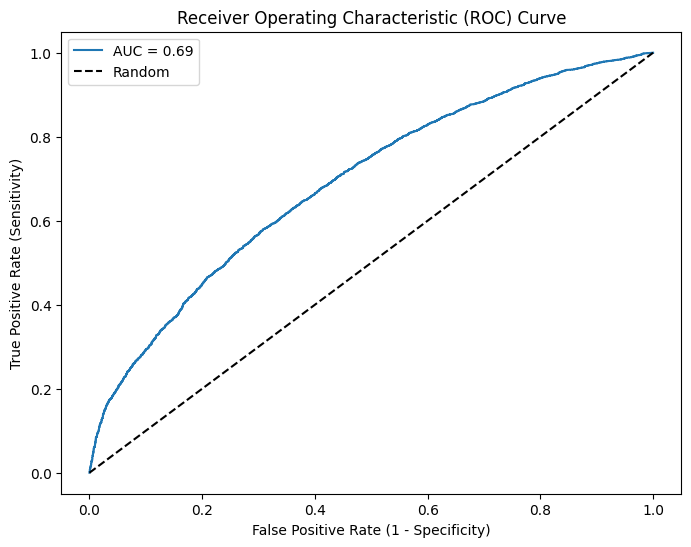

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

# Create a Logistic Regression model
model = LogisticRegression()

# Train the model on the training set
model.fit(X_train, y_train)

# Make probability predictions on the test set
y_prob = model.predict_proba(X_test)[:, 1]  # Probability of class 1

# Convert probabilities to binary predictions using a threshold
threshold = 0.5
y_pred = (y_prob > threshold).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print additional metrics
print("\nModel Evaluation on Test Set:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nConfusion Matrix:")
print(conf_matrix)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute AUC
auc_value = roc_auc_score(y_test, y_prob)

# Print AUC
print("\nArea Under the ROC Curve (AUC):", auc_value)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_value:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


Since this is a classification problem, the first model tested was a logistic regression. The model, its test statistics, and a confusion matrix are provided.

#### 5.2) Random Forest


Best Random Forest Hyperparameters: OrderedDict([('max_depth', 20), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 100)])

Random Forest - Cross-Validation Scores: 0.6890499999999999

Random Forest - Model Evaluation on Test Set:
Accuracy: 0.6925
Precision: 0.6893069306930693
Recall: 0.6980148385803088
F1 Score: 0.6936335558433795

Random Forest - Confusion Matrix:
[[3444 1569]
 [1506 3481]]

Area Under the ROC Curve (AUC): 0.7723373010001547


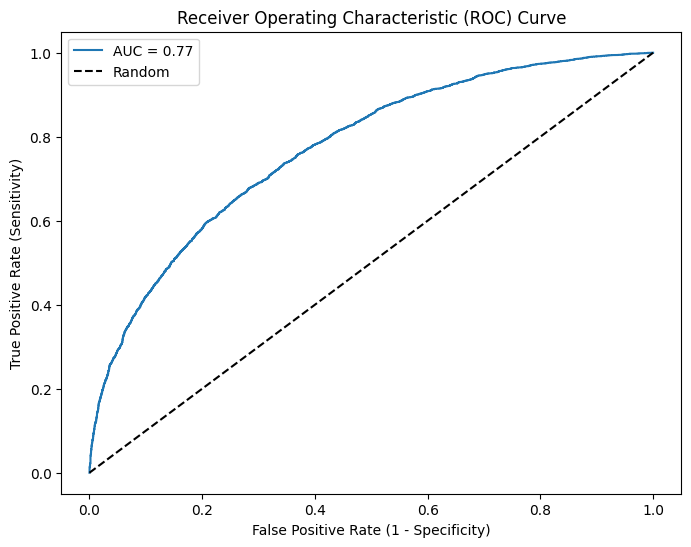

In [ ]:
import warnings
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Define the hyperparameter search space
param_space = {
    'n_estimators': (10, 100),
    'max_depth': (1, 20),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 20),
}

# Use BayesSearchCV to find the best hyperparameters for RandomForestClassifier
bayes_search_rf = BayesSearchCV(rf_model, param_space,
                                cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                scoring='accuracy', n_iter=50, random_state=42, n_jobs=-1)
bayes_search_rf.fit(X_train, y_train)

# Print the best hyperparameters
print("\nBest Random Forest Hyperparameters:", bayes_search_rf.best_params_)

# Train the RandomForestClassifier with the best hyperparameters
best_rf_model = bayes_search_rf.best_estimator_
best_rf_model.fit(X_train, y_train)

# Make probability predictions using RandomForestClassifier on the test set
y_pred_prob_rf = best_rf_model.predict_proba(X_test)[:, 1]

# Set a threshold to convert probabilities to binary predictions
threshold = 0.5
y_pred_rf = (y_pred_prob_rf > threshold).astype(int)


# Evaluate the RandomForestClassifier model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Print the results for RandomForestClassifier
print("\nRandom Forest - Cross-Validation Scores:", bayes_search_rf.best_score_)
print("\nRandom Forest - Model Evaluation on Test Set:")
print("Accuracy:", accuracy_rf)
print("Precision:", precision_rf)
print("Recall:", recall_rf)
print("F1 Score:", f1_rf)
print("\nRandom Forest - Confusion Matrix:")
print(conf_matrix_rf)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_rf)

# Compute AUC
auc_value = roc_auc_score(y_test, y_pred_prob_rf)

# Print AUC
print("\nArea Under the ROC Curve (AUC):", auc_value)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_value:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

Due to potential multicollinearity and non-linear relationships, a random forest model was implemented. This performed significantly better than the logisitic regression. The hyperparameters are fine tuned using a Bayesian search instead of a grid search to minimize the computing cost.

#### 5.3) KNN

Best Parameters: {'n_neighbors': 1}

Best KNN Model Evaluation on Test Set:
Accuracy: 0.6905
Precision: 0.6880715705765408
Recall: 0.6940044114698215
F1 Score: 0.6910252570629928

Confusion Matrix:
[[3444 1569]
 [1526 3461]]

Area Under the ROC Curve (AUC) for Best Model: 0.6905090878414337


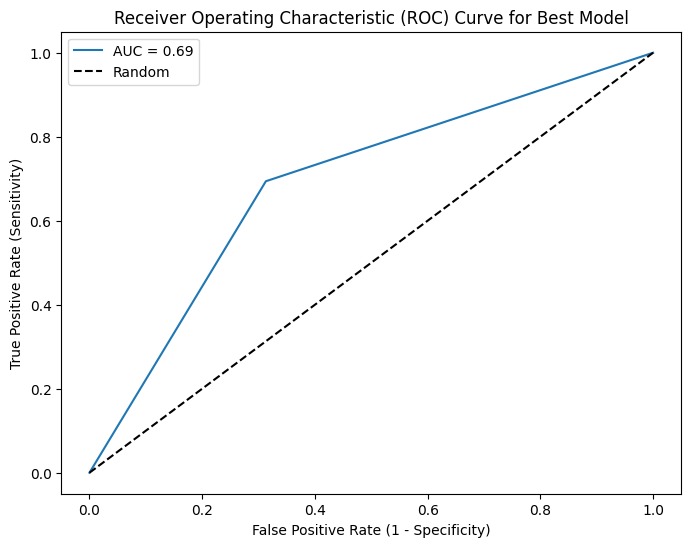

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Define the parameter grid for k
param_grid = {'n_neighbors': range(1, 21)}  # Adjust the range as needed

# Create a KNN model
knn_model = KNeighborsClassifier()

# Use StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(knn_model, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)

# Fit the model with cross-validation and find the best parameters
grid_search.fit(X_train, y_train)

# Get the best estimator and best parameters
best_knn_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print the best parameters
print("Best Parameters:", best_params)

# Make predictions on the test set
y_pred_prob_best_knn = best_knn_model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy_best_knn = accuracy_score(y_test, (y_pred_prob_best_knn > threshold).astype(int))
precision_best_knn = precision_score(y_test, (y_pred_prob_best_knn > threshold).astype(int))
recall_best_knn = recall_score(y_test, (y_pred_prob_best_knn > threshold).astype(int))
f1_best_knn = f1_score(y_test, (y_pred_prob_best_knn > threshold).astype(int))
conf_matrix_best_knn = confusion_matrix(y_test, (y_pred_prob_best_knn > threshold).astype(int))

# Print the results
print("\nBest KNN Model Evaluation on Test Set:")
print("Accuracy:", accuracy_best_knn)
print("Precision:", precision_best_knn)
print("Recall:", recall_best_knn)
print("F1 Score:", f1_best_knn)
print("\nConfusion Matrix:")
print(conf_matrix_best_knn)

# Compute ROC curve for the best model
fpr_best, tpr_best, thresholds_best = roc_curve(y_test, y_pred_prob_best_knn)

# Compute AUC for the best model
auc_value_best = roc_auc_score(y_test, y_pred_prob_best_knn)

# Print AUC for the best model
print("\nArea Under the ROC Curve (AUC) for Best Model:", auc_value_best)

# Plot ROC curve for the best model
plt.figure(figsize=(8, 6))
plt.plot(fpr_best, tpr_best, label=f'AUC = {auc_value_best:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve for Best Model')
plt.legend()
plt.show()

A KNN model was also fit onto the training data to see if it performed better than a random forest, but unfortuantely, its performance was closer to the logistic regression.

#### 5.4) XGBoost

XGBoost - Cross-Validation Scores:
Accuracy: 0.647775
Precision: 0.6496468787941048
Recall: 0.6425318692140316
F1 Score: 0.6460585652159898

XGBoost - Test Set Metrics:
Accuracy: 0.6582
Precision: 0.6596784042336657
Recall: 0.6498897132544617
F1 Score: 0.6547474747474749

Confusion Matrix (Test Set):
[[3341 1672]
 [1746 3241]]

Area Under the ROC Curve (AUC) - Test Set: 0.7193495228027742


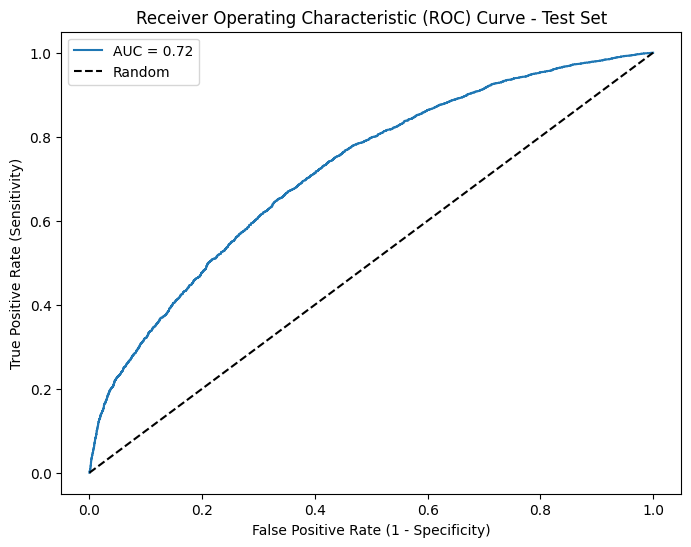

In [ ]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, auc, roc_curve

# Create an XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42)

# Use StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and get the scores
accuracy_scores = cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring='accuracy')
precision_scores = cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring='precision')
recall_scores = cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring='recall')
f1_scores = cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring='f1')

# Print the cross-validation scores
print("XGBoost - Cross-Validation Scores:")
print("Accuracy:", accuracy_scores.mean())
print("Precision:", precision_scores.mean())
print("Recall:", recall_scores.mean())
print("F1 Score:", f1_scores.mean())

# Train the XGBoost model on the entire training set
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Calculate and print metric scores for the test set
accuracy_test = accuracy_score(y_test, y_pred_xgb)
precision_test = precision_score(y_test, y_pred_xgb)
recall_test = recall_score(y_test, y_pred_xgb)
f1_test = f1_score(y_test, y_pred_xgb)

# Print metric scores for the test set
print("\nXGBoost - Test Set Metrics:")
print("Accuracy:", accuracy_test)
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1 Score:", f1_test)

# Confusion Matrix for the test set
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
print("\nConfusion Matrix (Test Set):")
print(conf_matrix_xgb)

# Compute ROC curve for the test set
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_xgb)

# Compute AUC for the test set
auc_value = auc(fpr, tpr)

# Print AUC for the test set
print("\nArea Under the ROC Curve (AUC) - Test Set:", auc_value)

# Plot ROC curve for the test set
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_value:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Set')
plt.legend()
plt.show()

Similar to a random forest, an XGBoost model was tried on the data. However, it seems that creating decision trees in parallel (RF) is better than in sequence (XG).

#### 5.5) Gradient Boosting Classifier

Cross-Validation Scores:
Accuracy: 0.633325

Test Set Metrics:
Accuracy: 0.6414
Precision: 0.6453621083212284
Recall: 0.62362141568077
F1 Score: 0.6343055272282276
Area Under ROC Curve: 0.6975098551666209


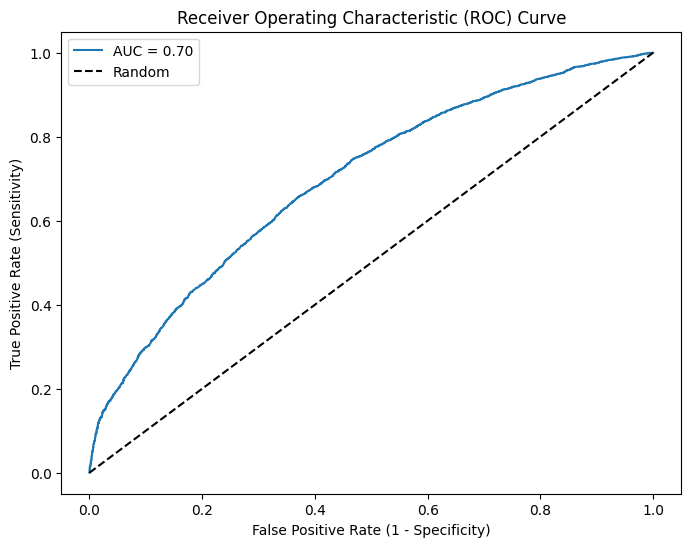


Confusion Matrix:
[[3304 1709]
 [1877 3110]]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix

# Assuming you have X_train, y_train, X_test, y_test

# Initialize the GradientBoostingClassifier with default parameters
gb_classifier = GradientBoostingClassifier()

# Initialize the StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation scores
cv_scores = cross_val_score(gb_classifier, X_train, y_train, cv=cv, scoring='accuracy')
print("Cross-Validation Scores:")
print("Accuracy:", np.mean(cv_scores))

# Fit the model on the training set
gb_classifier.fit(X_train, y_train)

# Evaluate on the test set
y_pred_gb = gb_classifier.predict(X_test)

# Calculate metrics
accuracy_gb = accuracy_score(y_test, y_pred_gb)
precision_gb = precision_score(y_test, y_pred_gb)
recall_gb = recall_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb)
roc_auc_gb = roc_auc_score(y_test, gb_classifier.predict_proba(X_test)[:, 1])

# Print metrics
print("\nTest Set Metrics:")
print("Accuracy:", accuracy_gb)
print("Precision:", precision_gb)
print("Recall:", recall_gb)
print("F1 Score:", f1_gb)
print("Area Under ROC Curve:", roc_auc_gb)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, gb_classifier.predict_proba(X_test)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_gb:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Confusion Matrix
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
print("\nConfusion Matrix:")
print(conf_matrix_gb)

A gradient boosting model was also fit, but the results were subpar.

#### With the highest ROC curve score and F1 score, we will utilize random forest model in predicting on our test data.

### 6) Predict on Test Data with Random Forest

#### 6.1) Create & Train Random Forest Model

In [ ]:
#Create our Random Forest

rf_model_test = RandomForestClassifier( #use selected hyperparameters
    random_state=42,
    max_depth=20,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=100
)

# Train the model on the training set
rf_model_test.fit(X, y)

RandomForestClassifier(max_depth=20, random_state=42)

#### 6.1) Create Test Data

##### 6.1.1) Get unique subset of data not present in training data to avoid leakage

Select a stratified subset from the test data in a similar manner to how it was done with the train data.

In [ ]:
from pyspark.sql import functions as F

# Convert the target column to integers (1 for True, 0 for False)
train_data_spark = train_data_spark.withColumn("HasDetections", train_data_spark["HasDetections"].cast("int"))

# Separate the positive and negative examples
positive_examples = train_data_spark.filter("HasDetections = 1")
negative_examples = train_data_spark.filter("HasDetections = 0")

# Calculate the number of examples needed for each class
num_examples_per_class = 100000 // 2

# Sample the positive and negative examples separately to get a balanced subset
balanced_subset = (
    positive_examples.sample(False, num_examples_per_class / positive_examples.count(), seed=42)
    .union(
        negative_examples.sample(False, num_examples_per_class / negative_examples.count(), seed=42)
    )
)

# Ensure that each row's "MachineIdentifier" is not present in train_data Pandas DataFrame
existing_machine_identifiers = set(train_machine_ids)
test_data = balanced_subset.filter(~F.col("MachineIdentifier").isin(existing_machine_identifiers))

# Show the resulting balanced subset
test_data.show()


+--------------------+------------+-------------+----------------+------------+------+----------------+----------------+-------------------------+-------------------------+-------------------+-----------------+------+-----------------+--------------+----------------------+-----------------+---------------------------+---------+---------+--------+-------+-------+--------------------+--------------------+----------+-----------+---------------+-------+-----+---------------+------------+--------+------------+---------------------+-------------------+------------------------+-------------------------+-------------------------+--------------------------------------+-------------------------------+---------------------+-------------------------------+--------------------------+--------------------------------+--------------------------+-----------------------+----------------------+-------------------------------------------------+-------------------------------------------------+------------

##### 6.1.2) Clean Test Data and Prepare it for Model Input

In [ ]:
test_data = test_data.toPandas()
target = test_data["HasDetections"]
test_data = test_data.drop(columns=columns_with_high_null_percentage)

In [ ]:
# Drop machine identifier
identifier = test_data["MachineIdentifier"]
test_data = test_data.drop(columns = {"MachineIdentifier"})

In [ ]:
# Get the list of original column names from selected_features
selected_original_columns = [col[0].split(":")[0] for col in selected_features]

# Print or use the list as needed
selected_original_columns =  set(selected_original_columns + numeric_columns)

In [ ]:
test_data = test_data[selected_original_columns]

In [ ]:
for col in binary_columns: #fills nulls in binary columns with -1
  if col in test_data.columns:
    test_data[col].fillna(-1, inplace=True)

for col in categorical_columns: #fills nulls in category columns
  if col in test_data.columns:
    test_data[col].fillna("No Category", inplace=True)

for col in numeric_columns: #fills nulls in numerical columns with mean
  if col in test_data.columns:
    test_data[col].fillna(test_data[col].mean(), inplace=True)

In [ ]:
non_categorical_columns_select = [col for col in test_data if col not in categorical_columns]

categorical_columns_select = [col for col in selected_original_columns if col not in non_categorical_columns_select]


In [ ]:
# One-hot encode the selected columns
test_data_encoded = pd.get_dummies(test_data, columns=categorical_columns_select, drop_first=True)


In [ ]:
scaler = StandardScaler()
numerical_scaled = scaler.fit_transform(test_data[numeric_columns])
# test_data = pd.DataFrame(numerical_scaled, columns=numeric_columns)

In [ ]:
numerical_scaled = pd.DataFrame(numerical_scaled, columns=numeric_columns) #standardize numerical columns

In [ ]:
X_validate = pd.concat([test_data_encoded[selected_categorical], numerical_scaled], axis=1)

#### 6.2) Predict with Model and Validate Test Data


Random Forest - Model Evaluation on Test Set:
Accuracy: 0.6256674313534957
Precision: 0.6320291595558646
Recall: 0.6011623246492986
F1 Score: 0.6162094430122327

Random Forest - Confusion Matrix:
[[32458 17465]
 [19902 29998]]

Area Under the ROC Curve (AUC): 0.6774546902430143


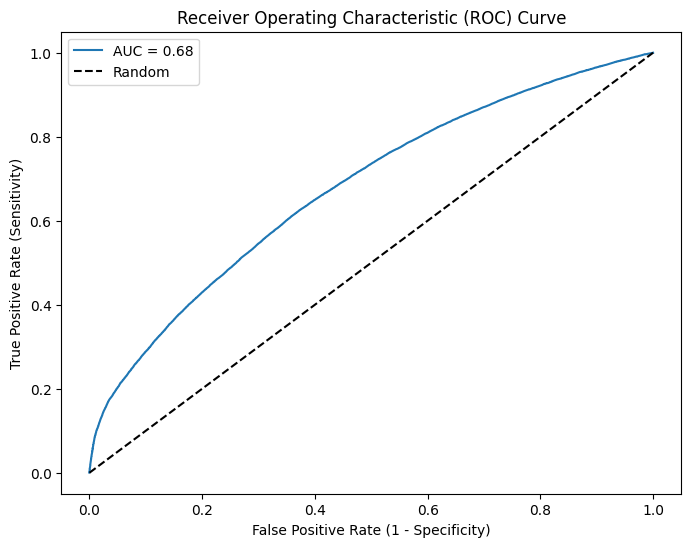

In [ ]:
# Make probability predictions using RandomForestClassifier on the test data
y_pred_prob_rf = rf_model_test.predict_proba(X_validate)[:, 1]

# Set a threshold to convert probabilities to binary predictions
threshold = 0.5
y_pred_rf = (y_pred_prob_rf > threshold).astype(int)


# Evaluate the RandomForestClassifier model
accuracy_rf = accuracy_score(target, y_pred_rf)
precision_rf = precision_score(target, y_pred_rf)
recall_rf = recall_score(target, y_pred_rf)
f1_rf = f1_score(target, y_pred_rf)
conf_matrix_rf = confusion_matrix(target, y_pred_rf)

# Print the results for RandomForestClassifier
print("\nRandom Forest - Model Evaluation on Test Set:")
print("Accuracy:", accuracy_rf)
print("Precision:", precision_rf)
print("Recall:", recall_rf)
print("F1 Score:", f1_rf)
print("\nRandom Forest - Confusion Matrix:")
print(conf_matrix_rf)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(target, y_pred_prob_rf)

# Compute AUC
auc_value = roc_auc_score(target, y_pred_prob_rf)

# Print AUC
print("\nArea Under the ROC Curve (AUC):", auc_value)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_value:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

Our random forest model performs well on the test dataset. In fact, if this model performed similarily on the test data provided by the Microsoft Competition, our model would have place 2nd overall based on the Area under ROC Curve. Due to RAM limitations however, we instead had to validate on subset of our training dataset instead. This is because the training dataset has both the features and target data. The test.csv provided by Microsoft does not have the target column. If we wanted to test our model performance against the competition test data, we would have to make over 7 million prediction then upload the predictions file to Kaggle to be scored. Due to RAM limitations we were unable to make all the required predictions and thus had to measure our final model performance with a 100k rows from our training data that were not used in training the mdel. Overall, our model is robust and accurately predicts malware attacks at a performance level that is on par or above other top models entered into the competition.